# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании - pазработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию и обосновать корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from random import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('***')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [3]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


Посмотрим на распределение признаков с помощью гистограмм:

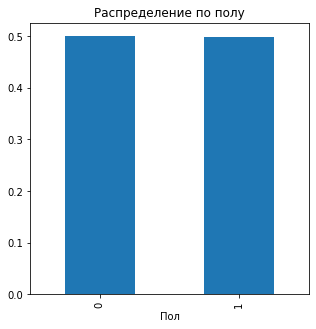

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))
df['Пол'].value_counts(normalize=True).plot(kind='bar') 
ax.set_title('Распределение по полу')
plt.xlabel('Пол');

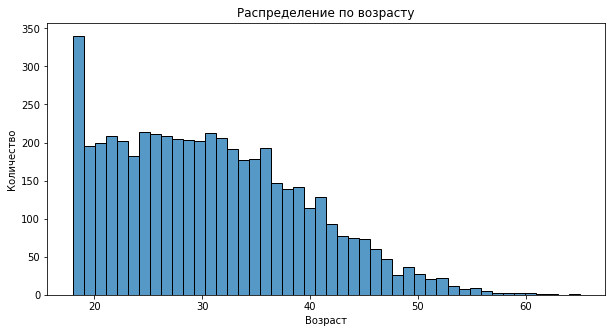

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(df['Возраст'], bins=len(df['Возраст'].unique()))
ax.set_title('Распределение по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество');

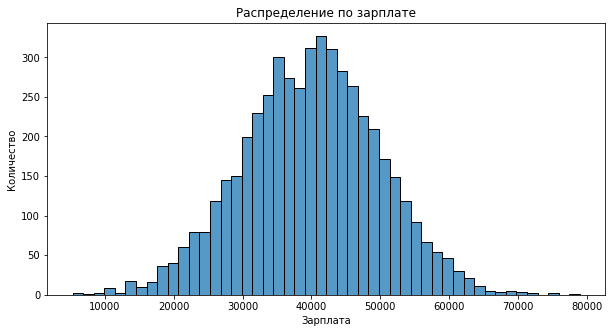

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(df['Зарплата'])
ax.set_title('Распределение по зарплате')
plt.xlabel('Зарплата')
plt.ylabel('Количество');

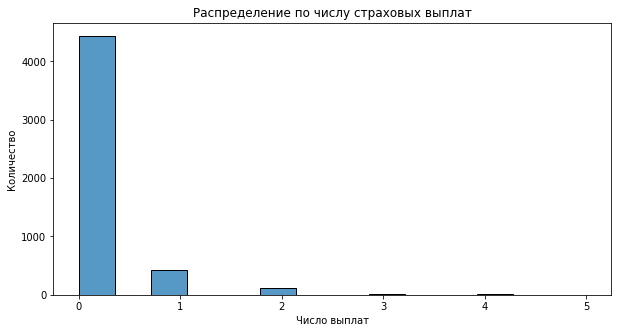

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(df['Страховые выплаты'])
ax.set_title('Распределение по числу страховых выплат')
plt.xlabel('Число выплат')
plt.ylabel('Количество');

Можно сделать вывод, что признаки распределены без выбросов и аномалий.

Далее посмотрим на взаимосвязь признаков:

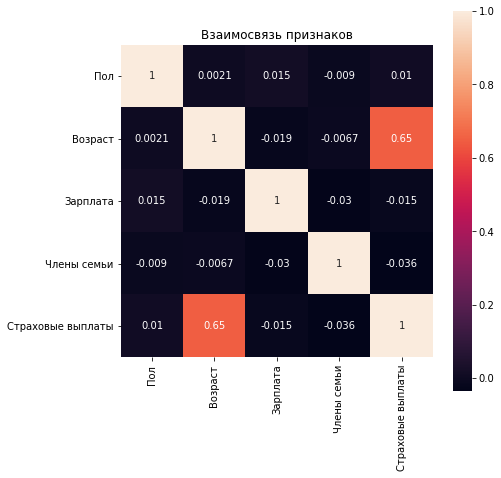

In [8]:
fig, ax = plt.subplots(figsize=(7,7)) 
sns.heatmap(df.corr(),annot = True, fmt = '.2g', ax=ax, square=True)
plt.title('Взаимосвязь признаков')
plt.show() 

In [9]:
df['Страховые выплаты'].corr(df['Возраст'])

0.6510300979467255

Можно сделать вывод, что больше всего на целевой признак оказывает влияние возраст клиента - коэффициент корреляции равен 0.65, то есть эти признаки можно назвать коллинеарными. 

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** при умножении на обратимую матрицу качество модели не изменится - значение метрики остаётся прежним.

**Обоснование:**  

Умножим матрицу признаков $X$ на cлучайную обратимую матрицу $P$:

    
$$
w_P = ((XP)^T XP)^{-1} (XP)^T y
$$   

Раскроем произведения в скобках:
$$
w_P = (P^TX^TXP)^{-1} P^TX^T y
$$  

Представим произведение в скобках как произведение 3х матриц:
$$
w_P = (P^T(X^TX)P)^{-1} P^TX^T y
$$  

Раскроем скобки:
$$
w_P = P^{-1}(X^T X)^{-1}(P^T)^{-1} P^TX^T y
$$  

Видим $(P^T)^{-1}$ и $P^T$, тк матрица обратимая, то их произведение равно единичной матрице:
$$
w_P = P^{-1}(X^T X)^{-1} X^Ty
$$  

Таким образом, 
$$ 
w_P = P^{-1}w
$$ 


Далее подставляем новое значение в формулу для нахождения предсказаний:

$$
a_P = XPw_P = XP P^{-1}w
$$

Также сокращаем $P^{-1}$ и $P$ и получаем

$$
a_P = Xw = a
$$

Значения предсказаний останутся прежними, соответственно и значения метрик совпадут.

## Алгоритм преобразования

**Алгоритм**

- создать случайную матрицу;
- проверить ее на обратимость;
- умножить признаки на полученную матрицу;
- найти метрику R2 на исходных и преобразованных данных и сравнить между собой.

## Проверка алгоритма

Разобьем данные на обучающую и тестовую выборки и определим признаки:

In [10]:
df_train, df_test = train_test_split(df, test_size=0.4, random_state=12345)

In [11]:
features_test_init = df_test.drop(['Страховые выплаты'], axis=1)
target_test = df_test['Страховые выплаты']

features_train_init = df_train.drop(['Страховые выплаты'], axis=1)
target_train = df_train['Страховые выплаты']

Обучим модель линейной регрессии на исходных данных и найдем значение метрики R2:

In [12]:
model = LinearRegression() 
model.fit(features_train_init, target_train) 
predictions_test = model.predict(features_test_init) 
r2_init = r2_score(target_test, predictions_test)

Далее создадим обратимую матрицу с размерностью, равной числу признаков. Для этого будем генерировать случайные матрицы, пока не получим матрицу с ненулевым детерминантом:

In [13]:
det = 0
while det == 0:
    random_matrix = np.random.randint(500, size=(features_test_init.shape[1], features_test_init.shape[1]))
    det = np.linalg.det(random_matrix) 

In [14]:
random_matrix

array([[267, 232,  31, 117],
       [ 42, 249,  12, 280],
       [ 82, 290, 360,  29],
       [ 71, 431,  13, 491]])

Умножим признаки на созданную случайную матрицу:

In [16]:
features_test_conv = features_test_init.dot(random_matrix)
features_train_conv = features_train_init.dot(random_matrix)
features_test_conv.head()

,0,1,2,3
3183,3199670.0,11319941.0,14040448.0,1142204.0
1071,3536442.0,12512312.0,15516626.0,1264882.0
2640,3454105.0,12218943.0,15156499.0,1231937.0
2282,2854440.0,10096980.0,12528240.0,1014800.0
1595,3282006.0,11611933.0,14400544.0,1173444.0


Расшифровать данные можно, умножив на матрицу, обратную к созданной, и округлив значения:

In [17]:
np.round(features_test_conv.dot(np.linalg.inv(random_matrix))).head()

,0,1,2,3
3183,0.0,33.0,39000.0,4.0
1071,0.0,50.0,43100.0,2.0
2640,1.0,39.0,42100.0,-0.0
2282,0.0,20.0,34800.0,-0.0
1595,0.0,41.0,40000.0,4.0


Обучим модель линейной регрессии на преобразованных данных и сравним значение метрики R2:

In [18]:
model = LinearRegression() 
model.fit(features_train_conv, target_train) 
predictions_test = model.predict(features_test_conv) 
r2_conv = r2_score(target_test, predictions_test)
print('R2 модели на исходных данных:       ', r2_conv)
print('R2 модели на преобразованных данных:', r2_init)
print('Pазница:', r2_init-r2_conv)

R2 модели на исходных данных:        0.4237517772621274
R2 модели на преобразованных данных: 0.42375177725680335
Pазница: -5.324074514589938e-12


Значения метрики R2 практически совпадают, качество регрессии не меняется.

## Вывод

По результатам проведенного исследования можно сделать вывод, что предложенный алгоритм выполняет поставленную задачу - при умножении матрицы признаков на случайную обратимую матрицу, визуально данные искажаются, но качество регрессии не меняется.